In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import gdown
import os
import scipy.optimize as optimize
import scipy.integrate as integrate
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

### Loading the Data

In [13]:
files = "./data1.txt"
if not os.path.exists(files):
    gdown.download(
        "https://drive.google.com/uc?id=1_jFxa2s7ONQ7nrhqFc1lARP6WChs2T4e",
        files
    )

In [14]:
import numpy as np
import fileinput

def read_data(filenames):
    """
    Reads a stream of events from the list of given files.
    
    Parameters
    ----------
    filenames : list
        List of filenames
    
    Stores
    -------    
    articles : [article_ids]
    features : [[article_1_features] .. [article_n_features]]
    events : [
                 0 : displayed_article_index (relative to the pool),
                 1 : user_click,
                 2 : [user_features],
                 3 : [pool_indexes]
             ]
    """

    global articles, features, events, n_arms, n_events
    articles = []
    features = []
    events = []

    skipped = 0

    with fileinput.input(files=filenames) as f:
        for line in f:
            cols = line.split()
            if (len(cols) - 10) % 7 != 0:
                skipped += 1
            else:
                pool_idx = []
                pool_ids = []
                for i in range(10, len(cols) - 6, 7):
                    id = cols[i][1:]
                    if id not in articles:
                        articles.append(id)
                        features.append([float(x[2:]) for x in cols[i + 1: i + 7]])
                    pool_idx.append(articles.index(id))
                    pool_ids.append(id)

                events.append(
                    [
                        pool_ids.index(cols[1]),
                        int(cols[2]),
                        [float(x[2:]) for x in cols[4:10]],
                        pool_idx,
                    ]
                )
    features = np.array(features)
    n_arms = len(articles)
    n_events = len(events)
    print(n_events, "events with", n_arms, "articles")
    if skipped != 0:
        print("Skipped events:", skipped)

In [15]:
#about the data
print("Reading data...")
read_data(files)
print("Done.")

Reading data...
100000 events with 21 articles
Done.


In [16]:
print("Number of events:", n_events)
#n_arms is analogus to chosing the number of arms in the bandit problem (The number of articles in the pool) like the number of arms in the bandit problem
print("Number of articles:", n_arms)
print("Number of features:", features.shape[1])
print("Article Shape:", len(articles))
print("Event Shape:", len(events))

Number of events: 100000
Number of articles: 21
Number of features: 6
Article Shape: 21
Event Shape: 100000


In [17]:
#pool_idx is the index of the article in the pool of articles.
event_df = pd.DataFrame(events, columns=["article_idx", "user_click", "user_features", "pool_idx"])
event_df.head(2)

,article_idx,user_click,user_features,pool_idx
0,17,0,"[1.2e-05, 0.0, 6e-06, 2.3e-05, 0.999958, 1.0]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]"
1,10,0,"[0.088932, 0.003915, 0.592269, 0.314084, 0.000801, 1.0]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]"


In [18]:
ctr_by_article = event_df.groupby(["article_idx",'user_click']).size()
ctr_by_article.head(4)

article_idx  user_click
0            0             4963
             1              103
1            0             4776
             1              136
dtype: int64

#### Observed Click Through Rate

In [19]:
ctr_by_article = ctr_by_article.unstack(level=1).reset_index()
ctr_by_article.rename(columns={0:'impressions',1:'clicks'},inplace=True)
ctr_by_article['ctr_observed'] = ctr_by_article['clicks']/ctr_by_article['impressions']
ctr_by_article

user_click,article_idx,impressions,clicks,ctr_observed
0,0,4963,103,0.020754
1,1,4776,136,0.028476
2,2,4962,173,0.034865
3,3,4882,168,0.034412
4,4,4829,116,0.024022
5,5,4771,183,0.038357
6,6,4830,127,0.026294
7,7,4996,98,0.019616
8,8,4821,74,0.015350
9,9,4744,114,0.024030


In [20]:
features_df = pd.DataFrame(features, columns=["article_feature_" + str(i) for i in range(features.shape[1])])
features_df.head(2)

,article_feature_0,article_feature_1,article_feature_2,article_feature_3,article_feature_4,article_feature_5
0,0.306008,0.00045,0.077048,0.230439,0.386055,1.0
1,0.306008,0.00045,0.077048,0.230439,0.386055,1.0


In [21]:
articles_df = pd.DataFrame(articles, columns=["article_id"])
articles_df.head(2)

,article_id
0,109498
1,109509


## Contextual multi-arm bandits (Future Extension)
- The contextual bandit problem is a generalization of the multi-armed bandit that extends the model by making actions conditional on the state of the environment. Unlike the classical multi-armed bandit, it addresses the problem of identifying the most appropriate content given all relevant contextual signals.

    - Player gets context xt .
    - Player selects at ∈ A .
    - Player gets reward Rt(at) .
    - Given the history of actions, rewards and contexts Player updates their strategy.


- Given a set of presented articles, a reward is determined by the click-through behavior of the user. If user clicks on the article, a payout of 1 is incurred and 0 otherwise. Click-through-rate (CRT) is used to determine the selection and placement of ads within the recommendation application.

### Traing a multi-arm bandits

- In the learning phase, the algorithm,
    - Step 1 it selects an action and 
    - Step 2 obtains a reward, 
    - Step 3 updates its estimates of expected rewards of actions given the context.
    
_*This is usually done via feeding a single example consisting of x,a,r (context, action, reward) to an estimator model doing a single update step (batch size 1).*_

- The learn phase is usually common for most algorithms and the main differences come from the exploration phase. Different Exploring-Exploitation Strategies could be
    - Epsilon Greedy
    - UCB
    - Thomson Sampling

### About the Dataset

Dataset: R6A - Yahoo! Front Page Today Module User Click Log Dataset, version 1.0 (1.1 GB)
- Selected dataset contains a fraction of user click log for news articles displayed in the Featured Tab of the Today Module on Yahoo! Front Page (http://www.yahoo.com) during the first ten days in May 2009. The articles were chosen uniformly at random from a hand-picked pool of high-quality articles, which allows one to use a recently developed method to obtain an unbiased evaluation of an arbitrary bandit algorithm.



- Columns

  * timestamp: e.g., 1241160900
  * displayed_article_id: e.g., 109513
  * user_click (0 for no-click and 1 for click): e.g., 0
  * strings "|user" and "|{article_id}" indicate the start of user
  and article features
  * features are encoded as "feature_id:feature_value" pairs, and feature_id starts from 1.

- The pool of available articles for recommendation for each user visit is the set of articles that appear in that line of data. All user IDs (specifically, bcookies) are replaced by a common string 'user' so that no user information can be identified from this data.

- Each user or article is associated with six features. Feature #1 is the constant (always 1) feature, and features #2-6 correspond to the 5 membership features constructed via conjoint analysis with a bilinear model.



## Epsilon Greedy

- A simple ϵ-greedy method. Here ϵ defines the amount of exploration we wish to perform, and for the remaining 1-ϵ times the model prefers exploitation. By convention, “epsilon” represents the percentage of time/trials dedicated for exploration, and it is also typical to do random exploration. This introduces some form of stochasticity.
- The choose_arm function returns the best arm's index based on the ϵ-greedy policy. The update functiom updates algorithm's parameters(matrices) for the selected arm. It looks at the selected arm, updates the number of times this arm was chosen, and then it updates the mean reward observed for the selected arm.

- In explore phase the algorithm, given its internal estimates of goodness of each actions chooses the best possible action modulo exploration. For example, epsilon-greedy chooses the best action with probability (1−ϵ) and with probability ϵ it selects uniformly one of all possible actions.

In [22]:
class Egreedy:
    """
    Epsilon greedy algorithm implementation
    """

    def __init__(self, epsilon):
        """
        Parameters
        ----------
        epsilon : number (Egreedy parameter, ideally between 0 and 1)
        """

        self.e = round(epsilon, 1)  # epsilon parameter for Egreedy 
        self.algorithm = "Egreedy (ε=" + str(self.e) + ")"
        #n_arms is analogus to chosing the number of arms in the bandit problem (The number of articles in the pool) like the number of arms in the bandit problem
        self.q = np.zeros(n_arms)  # average reward for each arm -- this represents the known mean reward for each arm
        self.n = np.zeros(n_arms)  # number of times each article was chosen by the user

    def choose_arm(self, t, user, pool_idx):
        """
        Returns the best arm's index relative to the pool
        Parameters
        ----------
        t : number (number of trial)
        user : array (user features)
        pool_idx : array of indexes (pool indexes for article identification)
        """

        p = np.random.rand()
        # This is where we are performing exploit-explore
        # the higher value of epsilon will favor on exploration
        if p > self.e: # we are exploiting the best action  
            max_index = np.argmax(self.q[pool_idx])  
            #print(f'Exploit: {max_index}, article: {articles[pool_idx[max_index]]}')    
            return max_index  #we return the article which has the highest average reward
        else: # exploring all the possible actions uniformly here
            return np.random.randint(low=0, high=len(pool_idx)) #we return a random article from the pool

    def update(self, displayed, reward, user, pool_idx):
        """
        Updates algorithm's parameters(matrices)
        Parameters
        ----------
        displayed : index (displayed article index relative to the pool)
        reward : binary (user clicked or not)
        user : array (user features)
        pool_idx : array of indexes (pool indexes for article identification)
        """
        #index of the article in the pool of articles that was displayed
        a = pool_idx[displayed]
        
        # update counts pulled for chosen article 
        self.n[a] += 1
        
        # update average/mean value/reward for chosen arm
        self.q[a] += (reward - self.q[a]) / self.n[a]
        """
        this can also be written as:
        value = self.q[a]
        new_value = ((self.n[a]-1)/float(self.n[a])) * value + (1 / float(self.n[a])) * reward
        self.q[a] = new_value
        """

In [23]:
import random
import time

def evaluate(A, size=100, learn_ratio = 0.9):
    """
    Policy evaluator as described in the paper
    Parameters
    ----------
    A : class (algorithm)
    size : number (run the evaluation only on a portion of the dataset)
    learn_ratio : number (perform learning(update parameters) only on a small portion of the traffic)
    Returns
    -------
    learn : array (contains the ctr for each trial for the learning bucket)
    deploy : array (contains the ctr for each trial for the deployment bucket)
    """
    
    start = time.time()
    # we initialize the payoff and events parameters separately for learning phase of the events and deployment phase of events.
    Payoff_deploy = 0 # total payoff for the deployment bucket
    Payoff_learn = 0  # total payoff for the learning bucket
    Events_deploy = 1 # counter of valid events for the deployment bucket
    Events_learn = 0  # counter of valid events for the learning bucket

    learn = []
    deploy = []
    global events
    if size != 100:
        k = int(n_events * size / 100)
        events = random.sample(events, k)

    """
    we run through the logged events, and treat each event either for learning & updating the parameters,
    or for deployment purposes wherein we use the reward obtained as evaluation metric
    """
    zzz = 0
    for t, event in enumerate(events):

        displayed = event[0] #index of the article in the pool of articles that was displayed to the user
        reward = event[1] #binary (user clicked or not)
        user = event[2] #array (user features)
        pool_idx = event[3] #array of indexes (pool indexes for article identification)

        # select the arm based on the bandit policy

        # Payoff_learn + Payoff_deploy -> Sums upto number of times the arms are pulled
        # this simultes the no. of trials in our case
        chosen = A.choose_arm(Payoff_learn + Payoff_deploy, user, pool_idx)
        
        """
        If, given the current history ht−1, it happens that the policy A chooses the same arm a
        as the one that was selected by the logging policy, then the event is retained
        (that is, added to the history), and the total payoff updated.
        Otherwise, if the policy A selects a different arm from the one that was taken by the logging policy,
        then the event is entirely ignored, and the algorithm proceeds to the next event without any change in its state.
        """
        if chosen == displayed: # if the chosen arm is the same as the displayed arm
            if random.random() < learn_ratio: # if the event is within the learning bucket
                Payoff_learn += event[1] # update the total payoff for the learning bucket
                Events_learn += 1 # update the total number of valid events for the learning bucket
                A.update(displayed, reward, user, pool_idx) # update the parameters of the algorithm for the learning bucket 
                learn.append(Payoff_learn / Events_learn) # update the ctr for the learning bucket
            else:
                Payoff_deploy += event[1] # update the total payoff for the deployment bucket
                Events_deploy += 1 # update the total number of valid events for the deployment bucket
                deploy.append(Payoff_deploy / Events_deploy) # update the ctr for the deployment bucket

    end = time.time()

    execution_time = round(end - start, 1)
    execution_time = (
        str(round(execution_time / 60, 1)) + "m"
        if execution_time > 60
        else str(execution_time) + "s"
    )
    print(
        "{:<20}{:<10}{}".format(
            A.algorithm, round(Payoff_deploy / Events_deploy, 4), execution_time
        )
    )
    return learn, deploy

In [40]:
ep_algo1 = Egreedy(0.1)
_, deploy = evaluate(ep_algo1,learn_ratio=0.5)

ep_algo1a = Egreedy(0.1)
_, deploy = evaluate(ep_algo1a,learn_ratio=0.75)


ep_algo2 = Egreedy(0.2)
_, deploy = evaluate(ep_algo2,learn_ratio=0.5)

ep_algo3 = Egreedy(0.5)
_, deploy = evaluate(ep_algo3,learn_ratio=0.5)

ep_algo4 = Egreedy(0.8)
_, deploy = evaluate(ep_algo4,learn_ratio=0.5)

Egreedy (ε=0.1)     0.0314    0.7s
Egreedy (ε=0.1)     0.0188    1.3s
Egreedy (ε=0.2)     0.03      1.2s
Egreedy (ε=0.5)     0.0265    0.7s
Egreedy (ε=0.8)     0.0262    0.5s


In [41]:
def epsilon_analysis(modeled_algo_instance, ctr_by_article):
    ctr_modeled = modeled_algo_instance.q
    article_displayed = modeled_algo_instance.n
    epsilon_algo_data = pd.DataFrame({"article_displayed_cnt": article_displayed, "ctr_modeled": ctr_modeled}).sort_values(by="ctr_modeled", ascending=False).reset_index()
    epsilon_algo_data.rename(columns={"index": "article_idx"}, inplace=True)
    ctr_by_article = ctr_by_article.merge(epsilon_algo_data, on="article_idx", suffixes=("_logged", "_modeled"))
    return ctr_by_article

In [42]:
epsilon_article_distribution = epsilon_analysis(ep_algo1, ctr_by_article)
epsilon_article_distribution

,article_idx,impressions,clicks,ctr_observed,article_displayed_cnt,ctr_modeled
0,0,4963,103,0.020754,229.0,0.021834
1,1,4776,136,0.028476,34.0,0.029412
2,2,4962,173,0.034865,9.0,0.000000
3,3,4882,168,0.034412,15.0,0.000000
4,4,4829,116,0.024022,14.0,0.000000
5,5,4771,183,0.038357,5.0,0.000000
6,6,4830,127,0.026294,8.0,0.000000
7,7,4996,98,0.019616,7.0,0.000000
8,8,4821,74,0.015350,9.0,0.000000
9,9,4744,114,0.024030,63.0,0.031746


## UCB Algorithm

In [43]:
class Ucb1:
    def __init__(self, alpha):
        """
        Parameters
        ----------
        alpha : number (ucb parameter)
        """

        self.alpha = round(alpha, 1)
        self.algorithm = "UCB1 (α=" + str(self.alpha) + ")"

        self.q = np.zeros(n_arms)  # average reward for each arm
        self.n = np.ones(n_arms)  # number of times each arm was chosen

    
    def choose_arm(self, t, user, pool_idx):
        """
        Choose an arm to pull based on the UCB1 algorithm
        
        """
        # calculate the ucb for each arm
        ucbs = self.q[pool_idx] + np.sqrt(self.alpha * np.log(t+1)/self.n[pool_idx]) 
        # index of the arm with the highest ucb
        max_index = np.argmax(ucbs)
        return max_index

    def update(self, displayed, reward, user, pool_idx):
        """
        Updates algorithm's parameters(matrices)
        Parameters
        ----------
        displayed : index (displayed article index relative to the pool)
        reward : binary (user clicked or not)
        user : array (user features)
        pool_idx : array of indexes (pool indexes for article identification)
        """
        # article or arm chosen by the algorithm
        a = displayed

        # update the number of times the arm was pulled
        self.n[a] += 1
        
        # update the average reward for the arm
        self.q[a] += (reward - self.q[a]) / self.n[a]


In [29]:
ucb_algo = Ucb1(.5)
_, deploy = evaluate(ucb_algo,learn_ratio=0.5)
rnd_ctr = deploy[-1]

ucb_algo1 = Ucb1(.75)
_, deploy1 = evaluate(ucb_algo1,learn_ratio=0.75)

ucb_algo2 = Ucb1(.9)
_, deploy2 = evaluate(ucb_algo2,learn_ratio=0.75)

ucb_algo3 = Ucb1(.25)
_, deploy3 = evaluate(ucb_algo3,learn_ratio=0.25)

UCB1 (α=0.5)        0.0193    1.7s
UCB1 (α=0.8)        0.0167    1.6s
UCB1 (α=0.9)        0.0165    1.6s
UCB1 (α=0.2)        0.0216    1.6s


In [45]:
ucb_algo3.q

array([0.        , 0.04166667, 0.        , 0.08108108, 0.00875274,
       0.04166667, 0.        , 0.        , 0.04166667, 0.05263158,
       0.04166667, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [46]:
ucb_articlee_distribution = epsilon_analysis(ucb_algo3, ctr_by_article)
ucb_articlee_distribution

,article_idx,impressions,clicks,ctr_observed,article_displayed_cnt,ctr_modeled
0,0,4963,103,0.020754,18.0,0.000000
1,1,4776,136,0.028476,24.0,0.041667
2,2,4962,173,0.034865,16.0,0.000000
3,3,4882,168,0.034412,37.0,0.081081
4,4,4829,116,0.024022,914.0,0.008753
5,5,4771,183,0.038357,24.0,0.041667
6,6,4830,127,0.026294,16.0,0.000000
7,7,4996,98,0.019616,16.0,0.000000
8,8,4821,74,0.015350,24.0,0.041667
9,9,4744,114,0.024030,19.0,0.052632


## Thomson Sampling

In [47]:
class thomsonSampling:
    def __init__(self, success, failure):
        """
        Parameters
        ----------
        alpha : number (ucb parameter)
        """


        self.algorithm = "Thomson (a=" + str(success) + ") (b=" + str(failure) + ")"

        self.a = np.ones(n_arms)*success  # success count for each arm
        self.b = np.ones(n_arms)*failure # failure count for each arm
        self.n = np.zeros(n_arms)  # number of times each arm was chosen

    
    def choose_arm(self, t, user, pool_idx):
        """
        Choose an arm to pull based on the UCB1 algorithm
        
        """
             
        thomson_sampling =[]
        for article_idx in pool_idx:
            a = self.a[article_idx] # a is the success count of the arm
            b= self.b[article_idx] # b is the failure count of the arm
            value = np.random.beta(a, b) # value is the probability of success of the the article(click)
            thomson_sampling.append(value)
        
        max_index = np.argmax(thomson_sampling) # we select the arm with the highest thomson sampling value (probability of success)
        return max_index 

    def update(self, displayed, reward, user, pool_idx):
        """
        Updates algorithm's parameters(matrices)
        Parameters
        ----------
        displayed : index (displayed article index relative to the pool)
        reward : binary (user clicked or not)
        user : array (user features)
        pool_idx : array of indexes (pool indexes for article identification)
        """

        article_id = pool_idx[displayed]

        self.a[article_id] += reward  # update the success count of the arm
        self.b[article_id] += 1-reward # update the failure count of the arm
        self.n[article_id] += 1 # update the number of times the arm (article) was chosen
        
        

In [50]:
thomson_algo1 = thomsonSampling(1,100)
_, deploy1 = evaluate(thomson_algo1)

thomson_algo2 = thomsonSampling(2, 100)
_, deploy2 = evaluate(thomson_algo2)

thomson_algo3 = thomsonSampling(3, 100)
_, deploy3 = evaluate(thomson_algo3)

thomson_algo4 = thomsonSampling(3.5, 100)
_, deploy4 = evaluate(thomson_algo4)

thomson_algo5 = thomsonSampling(1,10)
_, deploy5 = evaluate(thomson_algo5)

thomson_algo6 = thomsonSampling(.5,10)
_, deploy6 = evaluate(thomson_algo6)

thomson_algo7 = thomsonSampling(1.5,10)
_, deploy7 = evaluate(thomson_algo7)

thomson_algo8 = thomsonSampling(1,1)
_, deploy8 = evaluate(thomson_algo8)

Thomson (a=1) (b=100)0.0368    4.7s
Thomson (a=2) (b=100)0.0411    4.8s
Thomson (a=3) (b=100)0.0297    4.3s
Thomson (a=3.5) (b=100)0.0211    4.6s
Thomson (a=1) (b=10)0.0369    4.7s
Thomson (a=0.5) (b=10)0.0346    4.8s
Thomson (a=1.5) (b=10)0.0316    4.5s
Thomson (a=1) (b=1) 0.0348    5.8s


In [51]:
def thopson_analysis(modeled_algo_instance, ctr_by_article):
    ctr_modeled_a = np.array(modeled_algo_instance.a) # a is the success rate of the arm
    ctr_modeled_b = np.array(modeled_algo_instance.b) # b is the failure rate of the arm
    ctr_modeled = ctr_modeled_a / (ctr_modeled_a + ctr_modeled_b) # expected mean of the CTR of the modeled algorithm since its a beta distribution
    #expected_mean_reward = ctr_modeled_a / (ctr_modeled_b + ctr_modeled_a)
    article_displayed = modeled_algo_instance.n # number of times each arm was chosen
    epsilon_algo_data = pd.DataFrame({"article_displayed_cnt": article_displayed, "ctr_modeled": ctr_modeled}).sort_values(by="ctr_modeled", ascending=False).reset_index()
    epsilon_algo_data.rename(columns={"index": "article_idx"}, inplace=True)
    ctr_by_article = ctr_by_article.merge(epsilon_algo_data, on="article_idx", suffixes=("_logged", "_modeled"))
    return ctr_by_article

In [52]:
thomson_article_distribution = thopson_analysis(thomson_algo2, ctr_by_article)
thomson_article_distribution

,article_idx,impressions,clicks,ctr_observed,article_displayed_cnt,ctr_modeled
0,0,4963,103,0.020754,171.0,0.021978
1,1,4776,136,0.028476,142.0,0.020492
2,2,4962,173,0.034865,61.0,0.012270
3,3,4882,168,0.034412,425.0,0.028463
4,4,4829,116,0.024022,234.0,0.026786
5,5,4771,183,0.038357,136.0,0.016807
6,6,4830,127,0.026294,294.0,0.025253
7,7,4996,98,0.019616,101.0,0.014778
8,8,4821,74,0.015350,55.0,0.012739
9,9,4744,114,0.024030,411.0,0.031189


## Articles Sampled in Different Sampling Methods

#### Emsilon-greedy Sampling of Articles

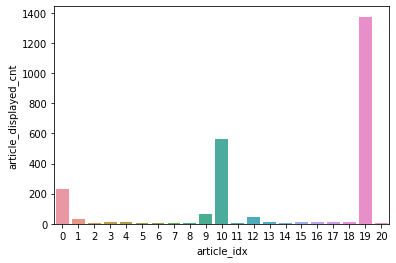

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x="article_idx", y="article_displayed_cnt", data=epsilon_article_distribution)

#### UCB Algorithm for Sampling Articles

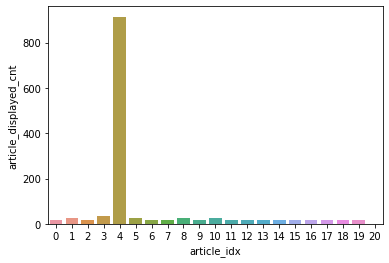

In [54]:
sns.barplot(x="article_idx", y="article_displayed_cnt", data=ucb_articlee_distribution)

#### Thompson Sampling

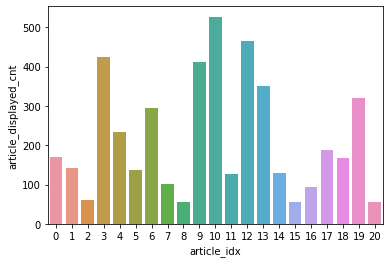

In [55]:
# Article distribution analysis
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x="article_idx", y="article_displayed_cnt", data=thomson_article_distribution)

## Results

- Thomson Sampling Outperforms UCB Algorithm and Epsilon-greedy Algorithm with CTR rate of 4%